In [1]:
import pickle
import unicodedata
import regex as re
import numpy as np
import unicodedata
import regex as re
import matplotlib.pyplot as plt
import random
import math
from tensorflow.keras.models import Model
import pandas as pd
from google.colab import drive
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,Dense,Softmax

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Creating data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/data_500k.csv")
df = df.dropna()
df.rename(columns = {'original':'correct',"modified":"wrong"}, inplace = True)
df.head()

,correct,wrong
0,they do not,they due not
1,they do to,they do too
2,i hope so,i hope so
3,she okay,she okay
4,let's go,let's go


## 2. Distribution of length of sentences

In [5]:
corr_lengths = df['correct'].str.split().apply(len)
wrng_lengths = df['wrong'].str.split().apply(len)


for i in range(0,101,10):
    print(i,np.percentile(corr_lengths, i))
for i in range(90,101):
    print(i,np.percentile(corr_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(corr_lengths, i))

0 1.0
10 4.0
20 5.0
30 6.0
40 8.0
50 10.0
60 12.0
70 15.0
80 19.0
90 27.0
100 552.0
90 27.0
91 29.0
92 30.0
93 32.0
94 34.0
95 37.0
96 40.0
97 45.0
98 51.0
99 65.0
100 552.0
99.1 67.0
99.2 69.0
99.3 73.0
99.4 76.0
99.5 80.0
99.6 86.0
99.7 93.0
99.8 104.0
99.9 124.0
100 552.0


> <font color="blue"><b>We observe the values, 99.2% of the data points are having length &lt; 70, so select the sentences that have words &lt; 70 </b> </font>

In [6]:
max_length = 70

## 3. Preparing data for ENCODER DECODER

In [ ]:
df['wrng_lengths'] = df['wrong'].str.split().apply(len)
df = df[df['wrng_lengths'] < 70]

df['corr_lengths'] = df['correct'].str.split().apply(len)
df = df[df['corr_lengths'] < 70]

df['corr_inp'] = '<start> ' + df['correct'].astype(str)
df['corr_out'] = df['correct'].astype(str) + ' <end>'

df = df.drop(['correct','corr_lengths','wrng_lengths'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
df.head()

,wrong,corr_inp,corr_out
0,they due not,<start> they do not,they do not <end>
1,they do too,<start> they do to,they do to <end>
2,i hope so,<start> i hope so,i hope so <end>
3,she okay,<start> she okay,she okay <end>
4,let's go,<start> let's go,let's go <end>


##4. Getting train and test 

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['corr_inp']= str(train.iloc[0]['corr_inp'])+' <end>'
train.iloc[0]['corr_out']= str(train.iloc[0]['corr_out'])+' <end>'

(481389, 3) (120348, 3)


In [ ]:
train.head()

,wrong,corr_inp,corr_out
481931,a runner cathedral woman,<start> a runner cathedral a woman <end>,a runner cathedral a woman <end> <end>
121168,shut up dillhole,<start> shut up dillhole,shut up dillhole <end>
10096,a fine night mrs peel,<start> a fine night mrs peel,a fine night mrs peel <end>
545169,go out and plug cord back in,<start> go out and plug the cord back in,go out and plug the cord back in <end>
55770,ware are you you're driving me crazy waiting l...,<start> where are you you're driving me crazy...,where are you you're driving me crazy waiting...


In [ ]:
validation.head()

,wrong,corr_inp,corr_out
134137,am i becoming repetitious,<start> am i becoming repetitious,am i becoming repetitious <end>
603004,they guard hour uyouu know borders knight and ...,<start> they guard our uyouu know borders nig...,they guard our uyouu know borders night and d...
174490,you gotta kid how old's your kid,<start> you gotta kid how old's your kid,you gotta kid how old's your kid <end>
59950,this shit's peanuts compared to what we gonna ...,<start> this shit's peanuts compared to what w...,this shit's peanuts compared to what we're gon...
493649,and then to prove your truly mine i'll plunder...,<start> and then to prove your truly mine i'...,and then to prove your truly mine i'll plund...


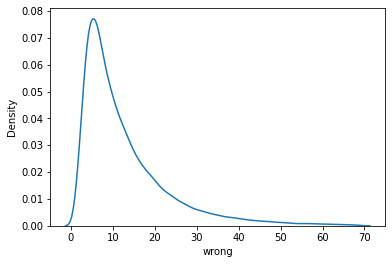

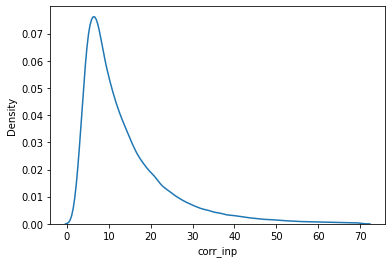

In [ ]:
wrng_lengths = train['wrong'].str.split().apply(len)
corr_lenths = train['corr_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(wrng_lengths)
plt.show()
sns.kdeplot(corr_lenths)
plt.show()

Observations:

1. We see majority of the sentences contains 0-40 words.
2. We have ignored sentences with length more than 70.

In [ ]:
train.to_csv("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/TRAIN AND VALIDATION/train.csv",index=False)

validation.to_csv("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/TRAIN AND VALIDATION/validation.csv",index=False)

## 5.Tokenization of data

In [ ]:
tknizer_wrng = Tokenizer()
tknizer_wrng.fit_on_texts(train['wrong'].values)


tknizer_corr = Tokenizer(filters='\t\n')
tknizer_corr.fit_on_texts(train['corr_inp'].values)

In [ ]:
vocab_size_wrng=len(tknizer_wrng.word_index.keys())
print(vocab_size_wrng)
vocab_size_corr=len(tknizer_corr.word_index.keys())
print(vocab_size_corr)

65901
65713


In [ ]:
tknizer_corr.word_index['<start>'], tknizer_corr.word_index['<end>']

(1, 57429)

In [ ]:
# saving
with open('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/tokenizer_wrong.pickle', 'wb') as handle:
    pickle.dump(tknizer_wrng, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving
with open('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/tokenizer_correct.pickle', 'wb') as handle:
    pickle.dump(tknizer_corr, handle, protocol=pickle.HIGHEST_PROTOCOL)

## LOAD

In [7]:
train = pd.read_csv("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/TRAIN AND VALIDATION/train.csv")

validation = pd.read_csv("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/TRAIN AND VALIDATION/validation.csv")

In [8]:
with open('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/tokenizer_wrong.pickle', 'rb') as handle:
    tknizer_wrng = pickle.load(handle)


with open('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/tokenizer_correct.pickle', 'rb') as handle:
    tknizer_corr = pickle.load(handle)

## 6.Creating embeddings for english sentences

In [9]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2022-11-12 17:35:54--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2022-11-12 17:35:54--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd890683824f09a63d3a1dbcd46.dl.dropboxusercontent.com/cd/0/inline/BwoD1NA-29Pv00dZn0ig6KmMCx96IuJmwCpdI4OtBUcPXPc4sCQ2sn6xOe8M-dBf0_EHVCO4KRhEOdITvk5BYntQHPxR29M9wYFESw5TFEF4UTWpj7oOc42TGZ6xyu5kOeXlwJ0Z7NdQjSViBolVxU45W6-Vu_ukLJ9llCD3eyo2pA/file# [following]
--2022-11-12 17:35:55--  https://ucd890683824f09a63d3a1dbcd46.dl.dropboxusercontent.com/cd/0/inline/BwoD1NA-29Pv00dZn0ig6KmMCx96IuJmwCpdI4OtBUcPXPc4sCQ2sn6xOe8M-d

In [10]:
vocab_size_wrng = 65901
vocab_size_corr = 65713

In [11]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix_enc = np.zeros((vocab_size_wrng+1, 100))
for word, i in tknizer_wrng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_enc[i] = embedding_vector



embedding_matrix_dec = np.zeros((vocab_size_corr+1, 100))
for word, i in tknizer_corr.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_dec[i] = embedding_vector

##7. <font color='blue'>**Implement ATTENTION MODEL**</font>

### 7.1 <font color='blue'>**Encoder**</font>

In [24]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length,**kwargs):

        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.input_length = input_length
        self.enc_units= lstm_size
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = 0,0,0
        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix_enc], trainable=False)
        # Intialize Encoder LSTM layer
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    
    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        print("ENCODER ==> INPUT SQUENCES SHAPE :",input_sequence.shape)
        input_embedd                           = self.embedding(input_sequence)
        print("ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE :",input_embedd.shape)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

      

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.lstm_state_h = np.zeros((batch_size,self.enc_units))
      self.lstm_state_c = np.zeros((batch_size,self.enc_units))


    def get_config(self):
      config = super(Encoder,self).get_config()
      config.update({
          'vocab_size': self.vocab_size,
          'embedding_dim':self.embedding_dim,
          'input_length':self.input_length,
          'enc_units':self.enc_units,
          'lstm_output':self.lstm_output,
          'lstm_state_h':self.lstm_state_h,
          'lstm_state_c':self.lstm_state_c,
          'embedding':self.embedding,
          'lstm':self.lstm,
      })
      return config


### 7.2 <font color='blue'>**Attention**</font>

In [25]:

#defing calss attention funactions

class Attention ( tf.keras.layers.Layer ) :

    def __init__ ( self , scoring_function , att_units ) :

        super().__init__( )
        self.scoring_function  = scoring_function
        self.att_units =  att_units
        if self.scoring_function == 'dot' :
            pass
        elif scoring_function == 'general' :
            # Intialize variables for geraneal fun needed
            self.wa = Dense ( att_units )
        elif scoring_function == 'concat' :
            self.w1 = Dense ( att_units )
            self.w2 = Dense ( att_units ) 
            self.v = Dense ( 1 )

    #defining call function
    def call ( self , decoder_hidden_state , encoder_output ):

        if self.scoring_function == 'dot' :
            state = tf.expand_dims ( decoder_hidden_state , -1 )
            score = tf.matmul ( encoder_output , state )
            weights  = tf.nn.softmax ( score , axis = 1 )
            weighted_out =  encoder_output * weights
            context_vec =  tf.reduce_sum ( weighted_out , axis = 1 )
            #returing its weights
            # print(context_vec)
            # print(weights)
            return context_vec , weights
        
        elif self.scoring_function == 'general' :
            state = tf.expand_dims ( decoder_hidden_state , 2 )                                    
            score = tf.matmul ( self.wa (encoder_output ) , state )                        
            weights = tf.nn.softmax ( score , axis = 1 )  
            weighted_out = encoder_output * weights
            context_vec = tf.reduce_sum ( weighted_out , axis = 1 )
            #return contextvec and weights           
            return context_vec , weights

        elif self.scoring_function  == 'concat' :         
            state = tf.expand_dims ( decoder_hidden_state , 1 )           
            score = self.v ( tf.nn.tanh ( self.w1 ( state ) + self.w2 ( encoder_output ) ) )
            weights = tf.nn.softmax ( score , axis = 1 )
            #weighted output
            weighted_out = encoder_output * weights            
            context_vec = tf.reduce_sum ( weighted_out , axis = 1 )            
            #returing weights       
            return context_vec , weights 


    def get_config(self):
      config = super(Attention,self).get_config()
      config.update({
          'scoring_function': self.scoring_function,
          'att_units':self.att_units,
          'wa':self.wa,
          'w1':self.w1,
          'w2':self.w2,
          'v':self.v
      })
      return config


### 7.3 <font color='blue'>**OneStepDecoder**</font>

In [26]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      #Initialize Embedding layer
      self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix_dec], trainable=False)
      #Intialize Decoder LSTM layer
      self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Encoder_LSTM") 
      #Intialize Dense layer(out_vocab_size) with activation='softmax'
      self.dense   = Dense(self.vocab_size)
      # self.dense   = Dense(self.vocab_size, activation='softmax')
      self.attention                                                         = Attention(self.score_fun,self.att_units)
      self.out_temp = []
      self.decoder_final_state_h,self.decoder_final_state_c = [],[]
      self.context_vector,self.attention_weights = [],[]
      self.concat = []
      



  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    target_embedd                                                                   = self.embedding(input_to_decoder)
    self.context_vector,self.attention_weights                                      = self.attention(state_h,encoder_output)

    self.concat = tf.concat([tf.expand_dims(self.context_vector,1),target_embedd],axis=-1)
    initial_states                                                                  = [state_h,state_c]
    decoder_output,self.decoder_final_state_h,self.decoder_final_state_c            = self.lstm(self.concat, initial_state=initial_states)
    # print("LSTM OUTPUT-->",decoder_output[:5])
    # decoder_output = tf.reshape(decoder_output,[tf.shape(decoder_output).numpy()[0],tf.shape(decoder_output).numpy()[2]])
    decoder_output = tf.reshape(decoder_output,(-1,decoder_output.shape[2]))
    output                                                                          = self.dense(decoder_output)
    # print("DENSE OUTPUT-->",output[:5])
    # print(decoder_output.shape)
    # print(output.shape)


    return output,self.decoder_final_state_h,self.decoder_final_state_c,self.attention_weights,self.context_vector
    # return np.array(output),self.decoder_final_state_h,self.decoder_final_state_c,self.attention_weights,self.context_vector

  
  def get_config(self):
      config = super(One_Step_Decoder,self).get_config()
      config.update({
          'vocab_size': self.vocab_size,
          'embedding_dim':self.embedding_dim,
          'input_length':self.input_length,
          'dec_units':self.dec_units,
          'score_fun':self.score_fun,
          'att_units':self.att_units,
          'embedding':self.embedding,
          'lstm':self.lstm,
          'dense':self.dense,
          'attention':self.attention,
          'out_temp':self.out_temp,
          'decoder_final_state_h':self.decoder_final_state_h,
          'decoder_final_state_c':self.decoder_final_state_c,
          'context_vector':self.context_vector,
          'attention_weights':self.attention_weights,
          'concat':self.concat,
      })
      return config




### 7.4 <font color='blue'>**Decoder**</font>

In [27]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      #Initialize Embedding layer
      self.onestep_decoder = One_Step_Decoder(self.vocab_size, self.embedding_dim, self.input_length, self.dec_units ,self.score_fun ,self.att_units)
      self.all_outputs = tf.TensorArray(tf.float32,size=2,name="output_arrays")

      


    
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        self.all_outputs = tf.TensorArray(tf.float32,size=tf.shape(input_to_decoder)[1],name="output_arrays")
      
        #Iterate till the length of the decoder input
        for timestep in range(tf.shape (input_to_decoder)[1]):
            # Call onestepdecoder for each token in decoder_input
            output,decoder_hidden_state,decoder_cell_state,_,_ = self.onestep_decoder(input_to_decoder[:,timestep:timestep+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            # Store the output in tensorarray
            self.all_outputs = self.all_outputs.write(timestep,output)
        # Return the tensor array.
        # print("self.all_outputs shape-->",self.all_outputs.size())
        # print("self.all_outputs-->",self.all_outputs)
        self.all_outputs = tf.transpose(self.all_outputs.stack(),[1,0,2])
        return self.all_outputs

    
    def get_config(self):
      config = super(One_Step_Decoder,self).get_config()
      config.update({
          'vocab_size': self.vocab_size,
          'embedding_dim':self.embedding_dim,
          'input_length':self.input_length,
          'dec_units':self.dec_units,
          'score_fun':self.score_fun,
          'att_units':self.att_units,
          'onestep_decoder':self.onestep_decoder,
          'all_outputs':self.all_outputs
      })
      return config
        
        
    

### 7.5 <font color='blue'>**Encoder Decoder model**</font>

In [28]:
max_length = 70
enc_units = 256
embedding_dim = 100

In [29]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size,score_fun):
    #Intialize objects from encoder decoder
    super().__init__()
    self.score_fun = score_fun
    self.encoder = Encoder(inp_vocab_size=vocab_size_wrng + 1, embedding_size=embedding_dim, input_length=encoder_inputs_length, lstm_size=enc_units)#https://stackoverflow.com/questions/48479915/what-is-the-preferred-ratio-between-the-vocabulary-size-and-embedding-dimension
    self.decoder = Decoder(out_vocab_size=vocab_size_corr + 1, embedding_dim=embedding_dim, input_length=decoder_inputs_length, dec_units=enc_units,score_fun=self.score_fun,att_units=enc_units)
    self.decoder_output = []
  
  
  def call(self,data):

    input,output = data[0],data[1]
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    print("="*20, "ENCODER", "="*20)
    batch_size = 16
    enc_initial_state = self.encoder.initialize_states(batch_size)
    encoder_output, encoder_h, encoder_c = self.encoder(input,enc_initial_state)
    print("ENCODER ==> OUTPUT SHAPE",encoder_output.shape)
    print("ENCODER ==> HIDDEN STATE SHAPE",encoder_h.shape)
    # print("ENCODER ==> CELL STATE SHAPE", encoder_c.shape)
    # print("="*20, "DECODER", "="*20)
    # Decoder initial states are encoder final states, Initialize it accordingly
    dec_initial_state = [encoder_h,encoder_c]
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    self.decoder_output                             = self.decoder(output, encoder_output,encoder_h,encoder_c)
    # return the decoder output
    return self.decoder_output


  def get_config(self):
    config = super(One_Step_Decoder,self).get_config()
    config.update({
        'score_fun':self.score_fun,
        'encoder':self.encoder,
        'decoder':self.decoder,
        'decoder_output':self.decoder_output
    })
    return config



### 7.6 <font color='blue'>**Custom loss function**</font>

In [30]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 7.7 <font color='blue'>Creating data pipeline

In [31]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['wrong'].values
        self.decoder_inps = data['corr_inp'].values
        self.decoder_outs = data['corr_out'].values
        self.wrng_tokenizer = tknizer_wrng
        self.corr_tokenizer = tknizer_corr
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.wrng_tokenizer.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.corr_tokenizer.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.corr_tokenizer.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

### 7.8 <font color='blue'>Model training

In [32]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

import tensorflow as tf
import datetime


log_dir="/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/TENSORBOARDS/dummy/logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/MODELS"+'/dummy.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_loss',verbose = 1),
    tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0.01, patience=2, verbose=1,  mode='auto',  baseline=None,  restore_best_weights=True),
    tensorboard_callback
]

In [21]:
validation.shape

(120348, 3)

In [53]:
train_dataset = Dataset(train, tknizer_wrng, tknizer_corr, max_length)
test_dataset  = Dataset(validation, tknizer_wrng, tknizer_corr, max_length)


train_dataloader = Dataloder(train_dataset, batch_size=256)
test_dataloader = Dataloder(test_dataset, batch_size=256)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print(test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

(256, 70) (256, 70) (256, 70)
(256, 70) (256, 70) (256, 70)


In [ ]:
full_model4 = encoder_decoder(encoder_inputs_length=max_length,decoder_inputs_length=max_length,output_vocab_size=vocab_size_corr,score_fun='dot')
optimizer = tf.keras.optimizers.Adam(0.001,clipnorm=0.001)
full_model4.compile(optimizer = optimizer,loss=loss_function)

In [25]:
history = full_model4.fit(train_dataloader, epochs=25, validation_data=test_dataloader,callbacks = callbacks)
full_model4.summary()

==================== ENCODER ====================
ENCODER ==> INPUT SQUENCES SHAPE : (256, 70)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (256, 70, 100)
ENCODER ==> OUTPUT SHAPE (256, 70, 256)
ENCODER ==> HIDDEN STATE SHAPE (256, 256)
Epoch 1/25
==================== ENCODER ====================
ENCODER ==> INPUT SQUENCES SHAPE : (None, None)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (None, None, 100)
ENCODER ==> OUTPUT SHAPE (None, None, 256)
ENCODER ==> HIDDEN STATE SHAPE (None, 256)
==================== ENCODER ====================
ENCODER ==> INPUT SQUENCES SHAPE : (None, None)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (None, None, 100)
ENCODER ==> OUTPUT SHAPE (None, None, 256)
ENCODER ==> HIDDEN STATE SHAPE (None, 256)
1880/1880 [==============================] - ETA: 0s - loss: 1.1978==================== ENCODER ====================
ENCODER ==> INPUT SQUENCES SHAPE : (None, None)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (None, None, 100)
ENCODER ==> OUTPUT SHAPE (

In [39]:
full_model4.save_weights("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/MODELS/FINAL_ATTENTION_BLEU_81.h5")

### 7.9 <font color='blue'>Loading the weights

In [35]:
dummy = encoder_decoder(encoder_inputs_length=max_length,decoder_inputs_length=max_length,output_vocab_size=vocab_size_corr,score_fun='dot')
optimizer = tf.keras.optimizers.Adam()
dummy.compile(optimizer = optimizer,loss=loss_function)
dummy.fit(train_dataloader, epochs=1, validation_data=test_dataloader,callbacks = callbacks)


dummy.load_weights('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/MODELS/FINAL_ATTENTION_BLEU_81.h5')


==================== ENCODER ====================
ENCODER ==> INPUT SQUENCES SHAPE : (4, 70)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (4, 70, 100)
ENCODER ==> OUTPUT SHAPE (4, 70, 256)
ENCODER ==> HIDDEN STATE SHAPE (4, 256)
==================== ENCODER ====================
ENCODER ==> INPUT SQUENCES SHAPE : (None, None)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (None, None, 100)
ENCODER ==> OUTPUT SHAPE (None, None, 256)
ENCODER ==> HIDDEN STATE SHAPE (None, 256)
==================== ENCODER ====================
ENCODER ==> INPUT SQUENCES SHAPE : (None, None)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (None, None, 100)
ENCODER ==> OUTPUT SHAPE (None, None, 256)
ENCODER ==> HIDDEN STATE SHAPE (None, 256)
25/25 [==============================] - ETA: 0s - loss: 1.8797==================== ENCODER ====================
ENCODER ==> INPUT SQUENCES SHAPE : (None, None)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (None, None, 100)
ENCODER ==> OUTPUT SHAPE (None, None, 256)
ENCODE

## 8. PREDICT

In [45]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''
  
  temp_token = tknizer_wrng.texts_to_sequences ( [ input_sentence ] )
  temp_token  = pad_sequences ( temp_token , maxlen = vocab_size_wrng , dtype = 'int32' , padding = 'post' )



  print("=" * 30, "Inference", "=" * 30)
  initial_state =  [np.zeros((1,64)) ,np.zeros((1,64))]
  enc_output, enc_state_h, enc_state_c = dummy.layers[0](np.expand_dims(temp_token[0], 0),initial_state)
  states_values = [enc_state_h, enc_state_c]

  dec_inp = np.array ( tknizer_corr.word_index ['<start>'] ).reshape( 1 , 1 )
  attention_weights_list = []


  predicted_eng = ""
  for i in range(max_length):

    predictions , enc_state_h , enc_state_c , attention_weights , context_vector = dummy.layers[ 1 ].onestep_decoder( dec_inp, enc_output , enc_state_h, enc_state_c )
    
    word_ind  = np.argmax ( predictions,-1 )
    pred_str = list ( tknizer_corr.word_index.keys( ) ) [ int ( word_ind - 1 ) ]

    attention_weights_list.append ( attention_weights [0,:,0 ] )

    predicted_eng+= pred_str + " "

    dec_inp = word_ind.reshape(1,1)

    if(pred_str == "<end>"):
      # print(predicted_eng)
      return predicted_eng, np.array ( attention_weights_list )
  return predicted_eng, np.array ( attention_weights_list )



In [46]:
import matplotlib
def plot_attention ( attention , sentence , predicted_sentence ) :
       
    sentence  = sentence.split()
    #final sentence declaration
    sentence  = sentence 
    
    predicted_sentence =  predicted_sentence.split() + [ '<end>' ]    
    fig = plt.figure(figsize =( 10 , 10 ))
    ax = fig.add_subplot (1 , 1 , 1)
    attention = attention [:len ( predicted_sentence ), :len(sentence) ]
    
    #matrix plot with proper arguments
    ax.matshow(attention, cmap = 'viridis', vmin = 0.0)

    
    #fontsize as 14
    fontdict = {'fontsize': 14}
    #seting up axis labels argument
    ax.set_xticklabels( [''] + sentence , fontdict = fontdict , rotation = 90 )
    ax.set_yticklabels( [''] + predicted_sentence , fontdict = fontdict)
    ax.xaxis.set_major_locator ( matplotlib.ticker.MultipleLocator (1) )
    ax.yaxis.set_major_locator ( matplotlib.ticker.MultipleLocator (1) )
    
    ax.set_xlabel ( 'Input text' )   
    ax.set_ylabel ( 'Output text' )
    
    #titles
    plt.suptitle ('Attention weights')



In [47]:
validation['wrong' ].values[ 321 ] , validation[ "corr_out" ].values[ 321 ]

('i sea you around ', "i'll see you around <end>")

In [48]:
#defining start time and end time
pred_sent,attention_weights   = predict ( validation['wrong'].values[ 321 ] )
pred_sent

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


'i see you around <end> '

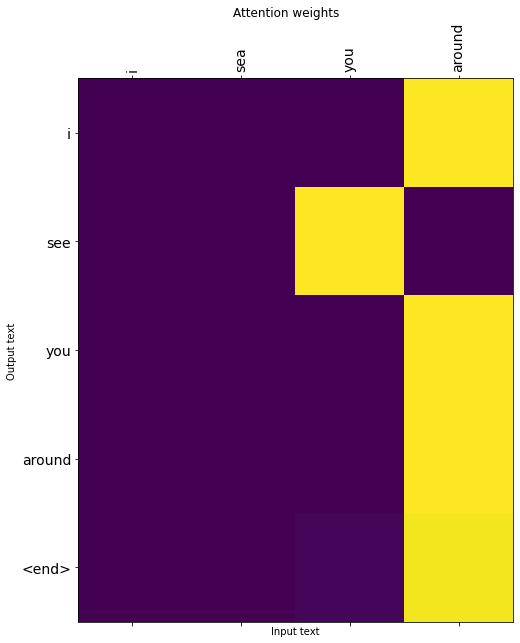

In [51]:
#plotting attention
plot_attention ( attention_weights , validation['wrong'].values[321] , pred_sent )

## 9. Calculating BLEU Score

In [49]:
test_data_sentences = list(train['wrong'])
test_data_sentences_output = list(train['corr_out'])

In [27]:
import random
from tqdm import tqdm
indexes = random.sample(range(0, 111499), 1000)
sentences_test = []
sentences_test_output = []
sentences_test_pred = []
for each in tqdm(indexes):

  sentences_test.append(test_data_sentences[each])
  sentences_test_output.append(test_data_sentences_output[each])
  ans,_ = predict(test_data_sentences[each])
  sentences_test_pred.append(ans)

  0%|          | 2/1000 [00:00<01:12, 13.82it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  0%|          | 4/1000 [00:00<02:09,  7.66it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  1%|          | 8/1000 [00:01<02:05,  7.88it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  1%|          | 9/1000 [00:01<02:04,  7.97it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  1%|          | 12/1000 [00:01<01:55,  8.57it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  1%|▏         | 14/1000 [00:01<02:18,  7.11it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  2%|▏         | 17/1000 [00:02<02:07,  7.73it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  2%|▏         | 19/1000 [00:02<02:24,  6.79it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  2%|▏         | 21/1000 [00:02<01:58,  8.23it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  2%|▏         | 23/1000 [00:02<01:36, 10.15it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  2%|▎         | 25/1000 [00:03<01:41,  9.64it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  3%|▎         | 27/1000 [00:03<01:48,  8.97it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  3%|▎         | 29/1000 [00:03<02:24,  6.72it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  3%|▎         | 30/1000 [00:03<02:14,  7.19it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  3%|▎         | 33/1000 [00:04<02:09,  7.44it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  4%|▎         | 35/1000 [00:04<02:09,  7.43it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  4%|▎         | 37/1000 [00:04<02:04,  7.73it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  4%|▍         | 39/1000 [00:04<01:45,  9.14it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  4%|▍         | 43/1000 [00:05<01:30, 10.56it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  4%|▍         | 45/1000 [00:05<01:42,  9.34it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  5%|▍         | 47/1000 [00:05<01:47,  8.83it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  5%|▍         | 49/1000 [00:06<02:22,  6.66it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  5%|▌         | 53/1000 [00:06<01:57,  8.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  6%|▌         | 55/1000 [00:06<02:03,  7.68it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  6%|▌         | 58/1000 [00:07<01:42,  9.20it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  6%|▌         | 60/1000 [00:07<02:19,  6.72it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  6%|▌         | 62/1000 [00:07<02:02,  7.67it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  6%|▋         | 63/1000 [00:08<02:25,  6.43it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  7%|▋         | 66/1000 [00:08<02:08,  7.26it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  7%|▋         | 67/1000 [00:08<02:21,  6.61it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  7%|▋         | 69/1000 [00:08<02:02,  7.60it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  7%|▋         | 72/1000 [00:09<02:11,  7.07it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  7%|▋         | 74/1000 [00:09<02:36,  5.92it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  8%|▊         | 78/1000 [00:10<01:43,  8.88it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  8%|▊         | 80/1000 [00:10<02:28,  6.18it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  8%|▊         | 83/1000 [00:10<02:01,  7.55it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  8%|▊         | 85/1000 [00:11<01:55,  7.90it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  9%|▊         | 87/1000 [00:11<01:58,  7.68it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  9%|▉         | 90/1000 [00:11<01:40,  9.07it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  9%|▉         | 93/1000 [00:12<01:52,  8.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


  9%|▉         | 94/1000 [00:12<02:14,  6.71it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 10%|▉         | 97/1000 [00:13<02:26,  6.15it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 10%|▉         | 99/1000 [00:13<02:06,  7.13it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 10%|█         | 101/1000 [00:13<02:25,  6.17it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 10%|█         | 104/1000 [00:14<02:16,  6.55it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 10%|█         | 105/1000 [00:14<02:41,  5.54it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 11%|█         | 107/1000 [00:14<02:18,  6.46it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 11%|█         | 110/1000 [00:14<02:05,  7.12it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : 

 11%|█         | 112/1000 [00:15<01:41,  8.79it/s]

(1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 11%|█▏        | 114/1000 [00:15<01:51,  7.93it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 12%|█▏        | 117/1000 [00:15<01:32,  9.59it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 12%|█▏        | 118/1000 [00:15<01:39,  8.86it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 12%|█▏        | 121/1000 [00:16<02:00,  7.30it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 12%|█▏        | 123/1000 [00:16<01:41,  8.64it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 12%|█▏        | 124/1000 [00:16<01:43,  8.46it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 13%|█▎        | 128/1000 [00:17<01:45,  8.29it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 13%|█▎        | 130/1000 [00:17<01:53,  7.69it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 13%|█▎        | 132/1000 [00:17<01:36,  9.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 13%|█▎        | 134/1000 [00:17<01:52,  7.69it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 14%|█▍        | 138/1000 [00:18<01:37,  8.83it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 14%|█▍        | 140/1000 [00:18<01:35,  8.97it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 14%|█▍        | 142/1000 [00:18<02:00,  7.11it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 14%|█▍        | 143/1000 [00:18<01:51,  7.67it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 15%|█▍        | 147/1000 [00:19<01:26,  9.86it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 15%|█▍        | 149/1000 [00:19<01:26,  9.85it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 15%|█▌        | 151/1000 [00:19<01:43,  8.19it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 15%|█▌        | 153/1000 [00:20<01:35,  8.91it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 15%|█▌        | 154/1000 [00:20<01:42,  8.27it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 16%|█▌        | 157/1000 [00:20<02:01,  6.96it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 16%|█▌        | 158/1000 [00:20<02:12,  6.36it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 16%|█▌        | 161/1000 [00:21<02:00,  6.96it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 16%|█▋        | 165/1000 [00:21<01:21, 10.22it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 17%|█▋        | 167/1000 [00:21<01:28,  9.36it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 17%|█▋        | 169/1000 [00:22<01:30,  9.13it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 17%|█▋        | 171/1000 [00:22<01:38,  8.38it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 17%|█▋        | 172/1000 [00:22<01:53,  7.27it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 17%|█▋        | 174/1000 [00:22<01:51,  7.44it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 18%|█▊        | 176/1000 [00:23<02:04,  6.61it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 18%|█▊        | 178/1000 [00:23<02:27,  5.57it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 18%|█▊        | 180/1000 [00:23<01:57,  6.97it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 18%|█▊        | 184/1000 [00:24<01:27,  9.34it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 18%|█▊        | 185/1000 [00:24<01:35,  8.51it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 19%|█▉        | 188/1000 [00:24<01:36,  8.40it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 19%|█▉        | 191/1000 [00:25<01:37,  8.31it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 19%|█▉        | 194/1000 [00:25<01:17, 10.34it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 20%|█▉        | 196/1000 [00:25<01:36,  8.37it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 20%|█▉        | 198/1000 [00:25<01:35,  8.38it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 20%|██        | 202/1000 [00:26<01:33,  8.51it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 20%|██        | 205/1000 [00:26<01:38,  8.10it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 21%|██        | 207/1000 [00:27<01:44,  7.58it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 21%|██        | 209/1000 [00:27<02:18,  5.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 21%|██        | 211/1000 [00:27<02:13,  5.93it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 22%|██▏       | 215/1000 [00:28<01:44,  7.48it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 22%|██▏       | 217/1000 [00:28<01:35,  8.22it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================


 22%|██▏       | 219/1000 [00:28<01:30,  8.60it/s]

ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 22%|██▏       | 221/1000 [00:28<01:26,  8.99it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 22%|██▏       | 224/1000 [00:29<01:21,  9.54it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 23%|██▎       | 226/1000 [00:29<01:30,  8.53it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 23%|██▎       | 229/1000 [00:29<01:23,  9.29it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 23%|██▎       | 231/1000 [00:30<01:21,  9.46it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 23%|██▎       | 233/1000 [00:30<01:34,  8.15it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 24%|██▎       | 235/1000 [00:30<01:35,  7.98it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 24%|██▎       | 237/1000 [00:30<01:20,  9.42it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 24%|██▍       | 241/1000 [00:31<01:28,  8.55it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 24%|██▍       | 244/1000 [00:31<01:16,  9.87it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 25%|██▍       | 246/1000 [00:31<01:14, 10.12it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 25%|██▍       | 248/1000 [00:32<01:29,  8.44it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 25%|██▍       | 249/1000 [00:32<01:49,  6.86it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 25%|██▌       | 251/1000 [00:32<01:46,  7.06it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 25%|██▌       | 253/1000 [00:32<01:56,  6.39it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 26%|██▌       | 256/1000 [00:33<01:55,  6.42it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 26%|██▌       | 259/1000 [00:33<01:33,  7.92it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 26%|██▌       | 262/1000 [00:34<01:30,  8.13it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 26%|██▋       | 264/1000 [00:34<01:19,  9.24it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 27%|██▋       | 267/1000 [00:34<01:17,  9.51it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 27%|██▋       | 269/1000 [00:34<01:06, 11.07it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 27%|██▋       | 273/1000 [00:35<00:58, 12.34it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 28%|██▊       | 275/1000 [00:35<01:02, 11.68it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 28%|██▊       | 277/1000 [00:35<00:55, 12.95it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 28%|██▊       | 279/1000 [00:35<01:14,  9.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 28%|██▊       | 282/1000 [00:36<01:40,  7.14it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 28%|██▊       | 284/1000 [00:36<01:29,  8.00it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 28%|██▊       | 285/1000 [00:36<01:36,  7.43it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 29%|██▉       | 288/1000 [00:37<01:28,  8.01it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 29%|██▉       | 292/1000 [00:37<01:22,  8.53it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)


 29%|██▉       | 294/1000 [00:37<01:24,  8.34it/s]

ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 30%|██▉       | 297/1000 [00:38<01:26,  8.13it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 30%|██▉       | 299/1000 [00:38<01:13,  9.56it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 30%|███       | 303/1000 [00:38<01:12,  9.62it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 30%|███       | 305/1000 [00:39<01:13,  9.41it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 31%|███       | 307/1000 [00:39<01:35,  7.23it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 31%|███       | 309/1000 [00:39<01:51,  6.20it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 31%|███       | 311/1000 [00:40<01:37,  7.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 31%|███▏      | 314/1000 [00:40<01:28,  7.72it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 32%|███▏      | 316/1000 [00:40<01:37,  7.00it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 32%|███▏      | 317/1000 [00:41<01:51,  6.13it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 32%|███▏      | 319/1000 [00:41<01:49,  6.22it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 32%|███▏      | 322/1000 [00:41<01:43,  6.56it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 32%|███▎      | 325/1000 [00:42<01:17,  8.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 33%|███▎      | 327/1000 [00:42<01:21,  8.31it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 33%|███▎      | 330/1000 [00:42<01:07,  9.91it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 33%|███▎      | 332/1000 [00:42<01:20,  8.26it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 33%|███▎      | 333/1000 [00:43<01:35,  6.98it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 33%|███▎      | 334/1000 [00:43<01:46,  6.25it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 34%|███▎      | 337/1000 [00:43<01:34,  6.99it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 34%|███▍      | 339/1000 [00:43<01:10,  9.37it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 34%|███▍      | 344/1000 [00:44<00:59, 10.97it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 35%|███▍      | 346/1000 [00:44<01:10,  9.33it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 35%|███▌      | 350/1000 [00:44<01:04, 10.09it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 35%|███▌      | 352/1000 [00:45<01:04, 10.02it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 36%|███▌      | 355/1000 [00:45<01:14,  8.65it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 36%|███▌      | 356/1000 [00:45<01:57,  5.47it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 36%|███▌      | 360/1000 [00:46<01:24,  7.58it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 36%|███▋      | 363/1000 [00:46<01:13,  8.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 37%|███▋      | 366/1000 [00:46<01:04,  9.82it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 37%|███▋      | 368/1000 [00:47<01:05,  9.59it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 37%|███▋      | 370/1000 [00:47<01:16,  8.20it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 37%|███▋      | 372/1000 [00:47<01:14,  8.48it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 38%|███▊      | 376/1000 [00:48<01:13,  8.46it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 38%|███▊      | 378/1000 [00:48<01:06,  9.30it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 38%|███▊      | 380/1000 [00:48<01:01, 10.03it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 38%|███▊      | 384/1000 [00:48<01:07,  9.12it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 39%|███▊      | 386/1000 [00:49<01:12,  8.49it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 39%|███▉      | 389/1000 [00:49<01:04,  9.50it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 39%|███▉      | 391/1000 [00:50<01:42,  5.95it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 39%|███▉      | 393/1000 [00:50<01:40,  6.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 40%|███▉      | 396/1000 [00:50<01:14,  8.14it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 40%|███▉      | 397/1000 [00:50<01:31,  6.61it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 40%|███▉      | 399/1000 [00:51<01:32,  6.53it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 40%|████      | 403/1000 [00:51<01:19,  7.50it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 40%|████      | 405/1000 [00:51<01:05,  9.02it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 41%|████      | 409/1000 [00:52<00:54, 10.83it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 41%|████▏     | 413/1000 [00:52<00:52, 11.25it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 42%|████▏     | 415/1000 [00:52<00:54, 10.82it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 42%|████▏     | 419/1000 [00:53<01:01,  9.38it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 42%|████▏     | 421/1000 [00:53<01:10,  8.27it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 42%|████▏     | 424/1000 [00:53<00:57, 10.06it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 43%|████▎     | 426/1000 [00:53<00:52, 10.96it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 43%|████▎     | 428/1000 [00:54<00:52, 10.80it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 43%|████▎     | 430/1000 [00:54<00:58,  9.81it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 43%|████▎     | 432/1000 [00:54<01:03,  9.01it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 44%|████▎     | 435/1000 [00:55<01:16,  7.43it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 44%|████▎     | 436/1000 [00:55<01:15,  7.49it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 44%|████▍     | 439/1000 [00:55<01:05,  8.55it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 44%|████▍     | 440/1000 [00:55<01:07,  8.30it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 44%|████▍     | 441/1000 [00:55<01:20,  6.96it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 44%|████▍     | 444/1000 [00:56<01:27,  6.36it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)


 45%|████▍     | 446/1000 [00:56<01:10,  7.81it/s]

ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 45%|████▍     | 448/1000 [00:56<01:00,  9.06it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 45%|████▌     | 451/1000 [00:57<01:01,  8.99it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 45%|████▌     | 453/1000 [00:57<01:23,  6.58it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)


 46%|████▌     | 455/1000 [00:57<01:07,  8.10it/s]

ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 46%|████▌     | 457/1000 [00:58<01:18,  6.92it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 46%|████▌     | 459/1000 [00:58<01:08,  7.87it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 46%|████▌     | 462/1000 [00:58<00:54,  9.87it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 46%|████▋     | 464/1000 [00:58<01:19,  6.76it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 47%|████▋     | 467/1000 [00:59<01:28,  6.01it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 47%|████▋     | 468/1000 [00:59<01:34,  5.61it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 47%|████▋     | 469/1000 [01:00<01:43,  5.14it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 47%|████▋     | 471/1000 [01:00<01:37,  5.43it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 47%|████▋     | 473/1000 [01:00<01:32,  5.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 48%|████▊     | 476/1000 [01:01<01:11,  7.34it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 48%|████▊     | 479/1000 [01:01<01:02,  8.28it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 48%|████▊     | 480/1000 [01:01<01:26,  6.01it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 48%|████▊     | 483/1000 [01:02<01:12,  7.10it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 48%|████▊     | 485/1000 [01:02<01:21,  6.33it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 49%|████▊     | 487/1000 [01:02<01:09,  7.34it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 49%|████▉     | 489/1000 [01:02<01:09,  7.33it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 49%|████▉     | 491/1000 [01:03<01:00,  8.43it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 49%|████▉     | 494/1000 [01:03<00:58,  8.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 50%|████▉     | 497/1000 [01:03<00:57,  8.68it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 50%|█████     | 500/1000 [01:04<01:04,  7.74it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 50%|█████     | 502/1000 [01:04<01:11,  7.00it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 51%|█████     | 506/1000 [01:04<00:44, 11.10it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 51%|█████     | 508/1000 [01:05<00:44, 11.10it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 51%|█████     | 510/1000 [01:05<00:57,  8.57it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 51%|█████▏    | 513/1000 [01:05<01:05,  7.39it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 52%|█████▏    | 515/1000 [01:05<00:53,  9.14it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 52%|█████▏    | 517/1000 [01:06<00:49,  9.78it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 52%|█████▏    | 519/1000 [01:06<01:00,  7.93it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 52%|█████▏    | 522/1000 [01:06<00:52,  9.10it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 52%|█████▏    | 524/1000 [01:06<00:45, 10.56it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 53%|█████▎    | 528/1000 [01:07<00:43, 10.79it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 53%|█████▎    | 531/1000 [01:07<00:56,  8.37it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 53%|█████▎    | 534/1000 [01:08<00:53,  8.67it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 54%|█████▎    | 536/1000 [01:08<00:49,  9.31it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 54%|█████▍    | 539/1000 [01:08<00:53,  8.54it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 54%|█████▍    | 541/1000 [01:08<00:57,  7.99it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 54%|█████▍    | 543/1000 [01:09<00:54,  8.36it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 55%|█████▍    | 545/1000 [01:09<01:01,  7.34it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 55%|█████▍    | 548/1000 [01:09<00:54,  8.33it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 55%|█████▌    | 551/1000 [01:10<00:50,  8.87it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 55%|█████▌    | 554/1000 [01:10<00:46,  9.52it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 56%|█████▌    | 556/1000 [01:10<01:01,  7.18it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 56%|█████▌    | 558/1000 [01:11<01:09,  6.40it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 56%|█████▌    | 561/1000 [01:11<00:51,  8.47it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 56%|█████▋    | 564/1000 [01:11<00:44,  9.85it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 57%|█████▋    | 566/1000 [01:12<00:46,  9.39it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 57%|█████▋    | 570/1000 [01:12<00:38, 11.31it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 57%|█████▋    | 572/1000 [01:12<00:38, 11.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 57%|█████▋    | 574/1000 [01:12<00:34, 12.41it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 58%|█████▊    | 576/1000 [01:12<00:40, 10.34it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 58%|█████▊    | 580/1000 [01:13<00:45,  9.28it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : 

 58%|█████▊    | 582/1000 [01:13<00:43,  9.54it/s]

(1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 58%|█████▊    | 584/1000 [01:13<00:38, 10.71it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 59%|█████▉    | 588/1000 [01:14<00:38, 10.58it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 59%|█████▉    | 590/1000 [01:14<00:40, 10.01it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 59%|█████▉    | 592/1000 [01:14<00:43,  9.35it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 59%|█████▉    | 594/1000 [01:15<01:04,  6.33it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 60%|█████▉    | 595/1000 [01:15<01:08,  5.93it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 60%|█████▉    | 597/1000 [01:15<01:10,  5.72it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 60%|█████▉    | 598/1000 [01:15<01:10,  5.71it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 60%|██████    | 600/1000 [01:16<01:27,  4.59it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 60%|██████    | 602/1000 [01:16<01:14,  5.37it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 60%|██████    | 604/1000 [01:16<00:50,  7.79it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 61%|██████    | 608/1000 [01:17<00:43,  8.98it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 61%|██████    | 610/1000 [01:17<00:42,  9.11it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 61%|██████    | 612/1000 [01:17<00:40,  9.50it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 61%|██████▏   | 614/1000 [01:18<00:44,  8.74it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 62%|██████▏   | 618/1000 [01:18<00:35, 10.66it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 62%|██████▏   | 620/1000 [01:18<00:34, 11.03it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 62%|██████▏   | 622/1000 [01:18<00:45,  8.37it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 62%|██████▏   | 624/1000 [01:19<00:39,  9.61it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 63%|██████▎   | 627/1000 [01:19<00:42,  8.82it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 63%|██████▎   | 629/1000 [01:19<00:42,  8.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 63%|██████▎   | 630/1000 [01:19<00:44,  8.33it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 63%|██████▎   | 634/1000 [01:20<00:37,  9.88it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 64%|██████▎   | 636/1000 [01:20<00:36,  9.94it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 64%|██████▍   | 638/1000 [01:20<00:35, 10.25it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 64%|██████▍   | 641/1000 [01:21<00:45,  7.90it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 64%|██████▍   | 644/1000 [01:21<00:37,  9.38it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 65%|██████▍   | 647/1000 [01:21<00:36,  9.58it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 65%|██████▍   | 648/1000 [01:21<00:41,  8.42it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 65%|██████▌   | 650/1000 [01:22<00:53,  6.52it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 65%|██████▌   | 653/1000 [01:22<00:40,  8.53it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 66%|██████▌   | 655/1000 [01:22<00:37,  9.18it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 66%|██████▌   | 657/1000 [01:22<00:33, 10.31it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 66%|██████▌   | 659/1000 [01:23<00:36,  9.46it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 66%|██████▌   | 660/1000 [01:23<00:47,  7.14it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 66%|██████▋   | 663/1000 [01:23<00:42,  7.90it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 67%|██████▋   | 666/1000 [01:24<00:37,  8.96it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 67%|██████▋   | 669/1000 [01:24<00:34,  9.65it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 67%|██████▋   | 671/1000 [01:24<00:33,  9.74it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 68%|██████▊   | 675/1000 [01:24<00:30, 10.62it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 68%|██████▊   | 677/1000 [01:25<00:30, 10.46it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 68%|██████▊   | 680/1000 [01:25<00:40,  7.93it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 68%|██████▊   | 681/1000 [01:25<00:48,  6.60it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 68%|██████▊   | 685/1000 [01:26<00:35,  8.78it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 69%|██████▊   | 687/1000 [01:26<00:34,  9.18it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 69%|██████▉   | 688/1000 [01:26<00:36,  8.62it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 69%|██████▉   | 690/1000 [01:26<00:35,  8.72it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 69%|██████▉   | 692/1000 [01:27<00:50,  6.08it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 69%|██████▉   | 693/1000 [01:27<00:49,  6.22it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 70%|██████▉   | 695/1000 [01:27<00:45,  6.76it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 70%|██████▉   | 697/1000 [01:27<00:35,  8.45it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 70%|██████▉   | 699/1000 [01:28<00:30,  9.85it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 70%|███████   | 701/1000 [01:28<00:48,  6.20it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 70%|███████   | 703/1000 [01:28<00:44,  6.73it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 70%|███████   | 705/1000 [01:29<00:46,  6.31it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 71%|███████   | 706/1000 [01:29<00:47,  6.21it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 71%|███████   | 710/1000 [01:29<00:38,  7.57it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE :

 71%|███████   | 711/1000 [01:30<00:41,  7.01it/s]

 (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 71%|███████▏  | 713/1000 [01:30<00:32,  8.80it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 72%|███████▏  | 715/1000 [01:30<00:29,  9.71it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 72%|███████▏  | 718/1000 [01:30<00:35,  7.93it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 72%|███████▏  | 721/1000 [01:31<00:29,  9.45it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 72%|███████▏  | 724/1000 [01:31<00:38,  7.23it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 73%|███████▎  | 726/1000 [01:31<00:31,  8.57it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 73%|███████▎  | 729/1000 [01:32<00:33,  8.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 73%|███████▎  | 731/1000 [01:32<00:31,  8.57it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 73%|███████▎  | 734/1000 [01:32<00:27,  9.60it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 74%|███████▎  | 735/1000 [01:32<00:28,  9.46it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 74%|███████▎  | 737/1000 [01:33<00:30,  8.60it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 74%|███████▍  | 739/1000 [01:33<00:32,  7.97it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 74%|███████▍  | 740/1000 [01:33<00:49,  5.27it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 74%|███████▍  | 743/1000 [01:34<00:45,  5.69it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 74%|███████▍  | 745/1000 [01:34<00:52,  4.87it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 75%|███████▍  | 747/1000 [01:35<00:48,  5.21it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 75%|███████▍  | 748/1000 [01:35<00:50,  4.97it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 75%|███████▌  | 752/1000 [01:35<00:34,  7.09it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 75%|███████▌  | 753/1000 [01:36<00:42,  5.86it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 76%|███████▌  | 755/1000 [01:36<00:37,  6.53it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 76%|███████▌  | 757/1000 [01:36<00:34,  7.01it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 76%|███████▌  | 760/1000 [01:37<00:38,  6.22it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 76%|███████▌  | 762/1000 [01:37<00:32,  7.41it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 76%|███████▋  | 763/1000 [01:37<00:36,  6.48it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 76%|███████▋  | 765/1000 [01:37<00:36,  6.46it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 77%|███████▋  | 766/1000 [01:38<00:41,  5.58it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 77%|███████▋  | 769/1000 [01:38<00:36,  6.37it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 77%|███████▋  | 772/1000 [01:38<00:30,  7.55it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 78%|███████▊  | 775/1000 [01:39<00:27,  8.32it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 78%|███████▊  | 776/1000 [01:39<00:33,  6.67it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 78%|███████▊  | 778/1000 [01:39<00:32,  6.88it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 78%|███████▊  | 781/1000 [01:40<00:28,  7.74it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 78%|███████▊  | 783/1000 [01:40<00:35,  6.16it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 79%|███████▊  | 786/1000 [01:40<00:28,  7.59it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 79%|███████▉  | 788/1000 [01:41<00:23,  8.86it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 79%|███████▉  | 790/1000 [01:41<00:21,  9.84it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 79%|███████▉  | 792/1000 [01:41<00:26,  7.96it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 80%|███████▉  | 795/1000 [01:42<00:28,  7.23it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)


 80%|███████▉  | 796/1000 [01:42<00:27,  7.40it/s]

ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 80%|███████▉  | 798/1000 [01:42<00:25,  8.05it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 80%|███████▉  | 799/1000 [01:42<00:25,  7.80it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 80%|████████  | 802/1000 [01:42<00:24,  8.05it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 80%|████████  | 804/1000 [01:43<00:21,  9.25it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 80%|████████  | 805/1000 [01:43<00:21,  9.01it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 81%|████████  | 807/1000 [01:43<00:22,  8.71it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 81%|████████  | 810/1000 [01:43<00:23,  8.24it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 81%|████████▏ | 813/1000 [01:44<00:22,  8.17it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 81%|████████▏ | 814/1000 [01:44<00:24,  7.63it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 82%|████████▏ | 816/1000 [01:44<00:29,  6.15it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 82%|████████▏ | 817/1000 [01:45<00:40,  4.50it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 82%|████████▏ | 818/1000 [01:45<00:49,  3.65it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 82%|████████▏ | 819/1000 [01:45<00:46,  3.90it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 82%|████████▏ | 820/1000 [01:45<00:44,  4.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 82%|████████▏ | 823/1000 [01:46<00:32,  5.48it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 82%|████████▎ | 825/1000 [01:46<00:26,  6.61it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 83%|████████▎ | 828/1000 [01:46<00:21,  8.11it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 83%|████████▎ | 830/1000 [01:47<00:23,  7.28it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 83%|████████▎ | 831/1000 [01:47<00:25,  6.76it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 83%|████████▎ | 832/1000 [01:47<00:28,  5.82it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 83%|████████▎ | 833/1000 [01:47<00:33,  5.03it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 84%|████████▎ | 837/1000 [01:48<00:21,  7.71it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 84%|████████▍ | 839/1000 [01:48<00:20,  7.86it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)


 84%|████████▍ | 841/1000 [01:48<00:16,  9.46it/s]

ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 84%|████████▍ | 844/1000 [01:48<00:16,  9.57it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 85%|████████▍ | 846/1000 [01:49<00:19,  7.89it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 85%|████████▍ | 848/1000 [01:49<00:17,  8.60it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)


 85%|████████▌ | 850/1000 [01:49<00:16,  9.01it/s]

ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 85%|████████▌ | 854/1000 [01:50<00:14, 10.43it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 86%|████████▌ | 858/1000 [01:50<00:14,  9.64it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 86%|████████▌ | 860/1000 [01:50<00:14,  9.86it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 86%|████████▌ | 862/1000 [01:51<00:16,  8.49it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 86%|████████▋ | 865/1000 [01:51<00:16,  8.39it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 87%|████████▋ | 867/1000 [01:51<00:15,  8.80it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 87%|████████▋ | 869/1000 [01:51<00:14,  8.87it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 87%|████████▋ | 871/1000 [01:52<00:14,  8.64it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 87%|████████▋ | 874/1000 [01:52<00:17,  7.19it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 88%|████████▊ | 877/1000 [01:52<00:13,  9.35it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 88%|████████▊ | 880/1000 [01:53<00:17,  6.74it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 88%|████████▊ | 882/1000 [01:53<00:17,  6.59it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 88%|████████▊ | 883/1000 [01:53<00:16,  6.91it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 88%|████████▊ | 885/1000 [01:54<00:18,  6.35it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 89%|████████▉ | 888/1000 [01:54<00:18,  6.12it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)


 89%|████████▉ | 890/1000 [01:54<00:14,  7.60it/s]

ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 89%|████████▉ | 893/1000 [01:55<00:12,  8.88it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 90%|████████▉ | 895/1000 [01:55<00:12,  8.30it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 90%|████████▉ | 898/1000 [01:55<00:10, 10.13it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 90%|█████████ | 901/1000 [01:56<00:11,  8.55it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 90%|█████████ | 903/1000 [01:56<00:11,  8.42it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 90%|█████████ | 905/1000 [01:56<00:11,  7.94it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 91%|█████████ | 908/1000 [01:57<00:13,  6.71it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 91%|█████████ | 911/1000 [01:57<00:14,  6.26it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 91%|█████████▏| 914/1000 [01:58<00:14,  5.90it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 92%|█████████▏| 918/1000 [01:58<00:11,  7.33it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 92%|█████████▏| 919/1000 [01:58<00:10,  7.66it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 92%|█████████▏| 922/1000 [01:59<00:10,  7.52it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 92%|█████████▎| 925/1000 [01:59<00:08,  8.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 93%|█████████▎| 927/1000 [02:00<00:11,  6.53it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 93%|█████████▎| 929/1000 [02:00<00:09,  7.40it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 93%|█████████▎| 931/1000 [02:00<00:07,  9.12it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 93%|█████████▎| 932/1000 [02:00<00:09,  7.20it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 93%|█████████▎| 934/1000 [02:01<00:09,  6.95it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 94%|█████████▎| 936/1000 [02:01<00:10,  5.84it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 94%|█████████▍| 938/1000 [02:01<00:08,  6.99it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 94%|█████████▍| 939/1000 [02:01<00:11,  5.26it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 94%|█████████▍| 941/1000 [02:02<00:09,  6.21it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 94%|█████████▍| 944/1000 [02:02<00:08,  6.70it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 95%|█████████▍| 946/1000 [02:02<00:07,  7.33it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 95%|█████████▍| 947/1000 [02:02<00:06,  7.66it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 95%|█████████▌| 950/1000 [02:03<00:08,  5.99it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 95%|█████████▌| 953/1000 [02:04<00:09,  4.96it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 96%|█████████▌| 955/1000 [02:04<00:07,  5.81it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 96%|█████████▌| 957/1000 [02:04<00:06,  7.09it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 96%|█████████▌| 961/1000 [02:05<00:05,  7.78it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 96%|█████████▋| 963/1000 [02:05<00:04,  8.54it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 96%|█████████▋| 964/1000 [02:05<00:04,  7.26it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 97%|█████████▋| 966/1000 [02:06<00:05,  5.75it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 97%|█████████▋| 968/1000 [02:06<00:04,  6.90it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 97%|█████████▋| 970/1000 [02:06<00:05,  5.44it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 97%|█████████▋| 971/1000 [02:07<00:06,  4.16it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 97%|█████████▋| 974/1000 [02:07<00:05,  5.04it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 98%|█████████▊| 976/1000 [02:08<00:04,  5.76it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 98%|█████████▊| 979/1000 [02:08<00:02,  7.48it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 98%|█████████▊| 981/1000 [02:08<00:02,  6.96it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 98%|█████████▊| 983/1000 [02:08<00:02,  7.62it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 98%|█████████▊| 985/1000 [02:09<00:01,  9.13it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 99%|█████████▊| 987/1000 [02:09<00:01,  7.16it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 99%|█████████▉| 989/1000 [02:09<00:01,  7.52it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 99%|█████████▉| 992/1000 [02:10<00:01,  7.59it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


 99%|█████████▉| 994/1000 [02:10<00:00,  7.52it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


100%|█████████▉| 996/1000 [02:10<00:00,  6.20it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


100%|█████████▉| 998/1000 [02:11<00:00,  6.47it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)
============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]

============================== Inference ==============================
ENCODER ==> INPUT SQUENCES SHAPE : (1, 65901)
ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE : (1, 65901, 100)


In [30]:
print(sentences_test[999])
print(sentences_test_output[999])
print(sentences_test_pred[999])

okay this is important 
okay this is important <end>
okay this is important <end> 


In [29]:
import warnings
warnings.filterwarnings('ignore')

import nltk.translate.bleu_score as bleu
total_score = 0


for i in tqdm(range(len(sentences_test_output))):
  reference = [sentences_test_output[i].split(),] # the original
  translation = sentences_test_pred[i].split()# trasilated using model
  total_score += bleu.sentence_bleu(reference, translation)

avg_score = total_score/1000
print("\navg_score",avg_score)

100%|██████████| 1000/1000 [00:00<00:00, 7459.06it/s]


avg_score 0.8140663037747174


OBSERVATIONS:




1.   Using simple ENCODER DECODER MODEL, we got a best validation_loss of 0.18 and an average BLEU score for 1000 random sentences of about 71%.
2.   Using simple encoder decoder model WITH ATTENTION MECHANISM, we got a best validation_loss of 0.18 and an average BLEU score for 1000 random sentences of about 81% and according to https://cloud.google.com/translate/automl/docs/evaluate it is a pretty good score.



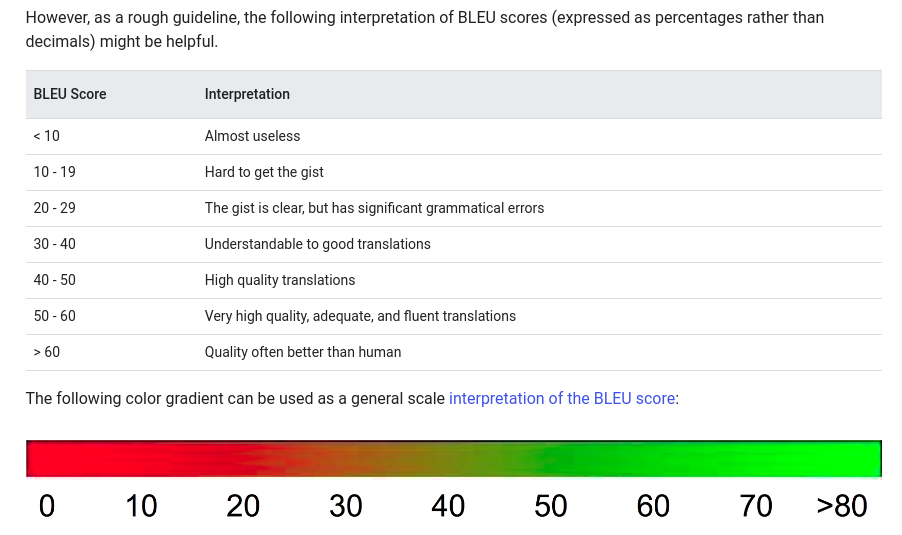

